In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.decomposition import PCA
# Reading in the data
df = pd.read_csv("beer_profile_and_ratings.csv")

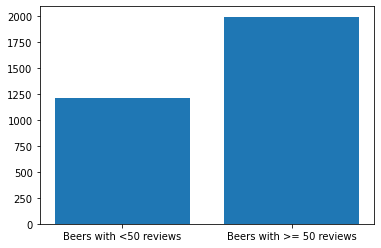

In [3]:
# A lot of beers have a limited amount of reviews
# Let's try to visualize how many there are
plt.bar(["Beers with <50 reviews", "Beers with >= 50 reviews"], [df[df['number_of_reviews'] < 50].shape[0], df[df['number_of_reviews'] >= 50].shape[0]])
plt.show()

# Since we want to use only truthful reviews,
# the beers having less than 50 reviews are dropped
df.drop(df[df['number_of_reviews'] < 50].index, inplace = True)
df.reset_index(inplace = True, drop = True)

[]

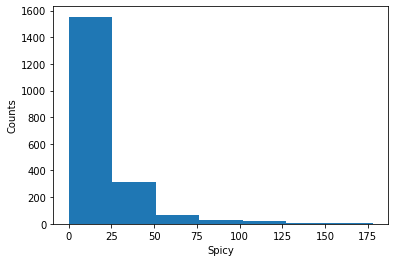

In [4]:
# Some of the dataset columns are extremly lopsided
# Here's an example:
plt.hist(df['Spices'], bins=7)
plt.xlabel('Spicy')
plt.ylabel('Counts')
plt.plot()

In [5]:
# Create the new, categorical columns (before deleting the old ones)
# All the columns are gonna be deleted, except ABV and review_overall
all_features = list(df.columns)
all_features.remove('review_overall')
all_features.remove('ABV')
categorical_columns = ['Astringency', 'Body', 'Bitter', 'Sweet', 'Sour', 'Fruits', 'Spices']

labels = [0, 1, 2, 3]
for i in range(len(categorical_columns)):
    column = categorical_columns[i]
    
    # Here, we're trying to split the data into bins of +/- equal size
    # However, since some values appear more than 1/4 of the time (as for example salty appears 1527 with value 0)
    # There's no solution but to increase the lower bound of the next interval (and all the ones following)
    theSplit = np.array_split(np.sort(df[column]), 4)
    intervals = list(map(lambda x: x[0], theSplit))
    for i in range(1, len(intervals)):
        if intervals[i] <= intervals[i - 1]:
            intervals[i] = intervals[i - 1] + 1
    intervals.append(theSplit[-1][-1])
    
    categorized = pd.cut(df[column], bins = intervals, labels = labels, include_lowest = True).cat.codes
    df.insert(i + 2, column.lower(), categorized)

# Drop the unnecessary/useless columns
df.drop(all_features, axis = 1, inplace = True)
df.shape

(1990, 9)

In [6]:
# the manually selected interval bounds
# high-quality beers are the ones with >=4.5 rating
# good beers have rating between 4 and 4.5
# average beers have ratings between 3.5 and 4
# and bad beers have ratings under 3.5
intervals = [1, 3.5, 4, 4.25, 5]

# creating the features and labels 
X = df.drop(['review_overall'], axis = 1)
y = pd.cut(df['review_overall'], bins = intervals, labels = labels, include_lowest = True).cat.codes
y.value_counts()

1    1067
2     485
0     335
3     103
dtype: int64

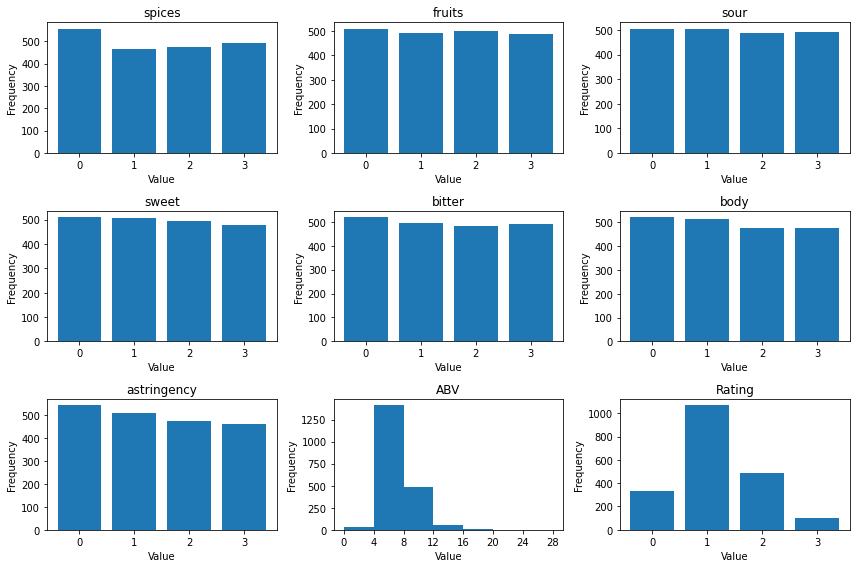

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    if i < X.shape[1] - 1:
        valueCounts = X.iloc[:, i].value_counts()
        ax.bar(valueCounts.index, valueCounts.values)
        ax.set_title(X.columns[i])
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    elif i == X.shape[1] - 1:
        hist, bins, _ = ax.hist(X.iloc[:, i], bins=7)
        ax.set_title(X.columns[i])
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_xticks(bins)
    else:
        ax.bar(y.value_counts().index, y.value_counts().values)
        ax.set_title("Rating")
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

plt.tight_layout()

In [8]:
# Notice that the columns correlating the most with higher overall reviews
# are ABV, fruity, and body
pd.concat([X, y], axis = 1).corr()[0].drop([0]).sort_values(ascending = False)

ABV            0.314279
fruits         0.272095
body           0.264705
spices         0.248559
sour           0.220229
sweet          0.201172
bitter         0.193342
astringency    0.078735
Name: 0, dtype: float64

In [9]:
# splitting data into train/test
X_model, X_test, y_model, y_test = train_test_split(X, y, test_size = 0.3)
stratKFold = StratifiedKFold(shuffle = True)

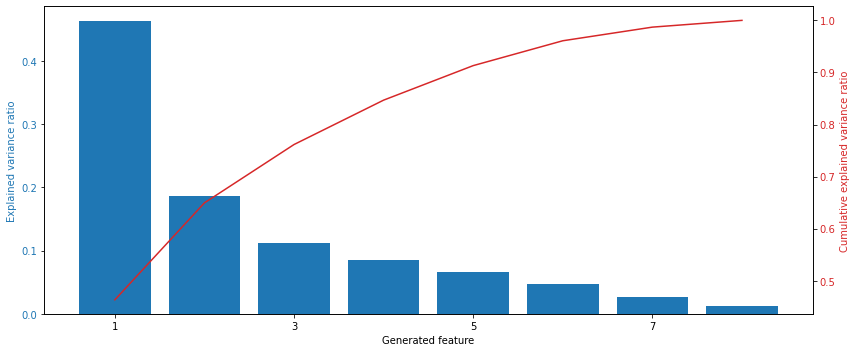

In [10]:
# Let's try to apply PCA on the data before using the second method
N = X.shape[1]
pca = PCA(n_components = N)
X_transformed = pca.fit_transform(X_model)

fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()


In [11]:
# Notice that the first 3 generated features have variance ratio above 0.1
# so we'll be using N = 3 during our PCA training
N = 3
# Additionally, to get some real-world feel of what these features mean
# Let's print the columns that correlate the most with each new feature:
dimensionCorr = pd.DataFrame(pca.components_,columns=X.columns).abs().idxmax(axis = 'columns')
for i in range(N):
    print(f"The feature correlating the most with new feature nr. {i + 1} is {dimensionCorr[i]}")

The feature correlating the most with new feature nr. 1 is ABV
The feature correlating the most with new feature nr. 2 is sour
The feature correlating the most with new feature nr. 3 is bitter


In [12]:
# lists to save the train accuracies, validation accuracies, and the models themselves
y_train_rec_rfc = []
y_valid_rec_rfc = []
y_train_rec_lg = []
y_valid_rec_lg = []
rfcs = []
lgs = []

for tr, val in stratKFold.split(X_model, y_model):
    X_train = X_model.iloc[tr] 
    X_val   = X_model.iloc[val]
    y_train = y_model.iloc[tr]
    y_val   = y_model.iloc[val]

    # creating and training the model
    rfc = RandomForestClassifier(criterion = 'gini', min_samples_split = 10)
    rfc.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, rfc.predict(X_train))
    y_train_rec_rfc.append(train_accuracy)

    valid_accuracy = accuracy_score(y_val, rfc.predict(X_val))
    y_valid_rec_rfc.append(valid_accuracy)
    rfcs.append(rfc)

    pca = PCA(n_components = N)
    X_train_tf = pca.fit_transform(X_train)
    X_val_tf   = pca.transform(X_val)

    lg = LogisticRegression()
    lg.fit(X_train_tf, y_train)
    train_accuracy_lg = accuracy_score(y_train, lg.predict(X_train_tf))
    y_train_rec_lg.append(train_accuracy_lg)

    valid_accuracy_lg = accuracy_score(y_val, lg.predict(X_val_tf))
    y_valid_rec_lg.append(valid_accuracy_lg)

    lgs.append((lg, pca))

In [13]:
print(f"The training accuracy scores for RFCs are {y_train_rec_rfc}")
print(f"The validation accuracy scores for RFCs are {y_valid_rec_rfc}")
print(f"The training accuracy scores for LRs are {y_train_rec_lg}")
print(f"The validation accuracy scores for LRs are {y_valid_rec_lg}")

The training accuracy scores for RFCs are [0.7684021543985637, 0.7621184919210053, 0.7504488330341114, 0.7569506726457399, 0.7632286995515695]
The validation accuracy scores for RFCs are [0.5913978494623656, 0.5734767025089605, 0.5842293906810035, 0.5755395683453237, 0.6294964028776978]
The training accuracy scores for LRs are [0.59245960502693, 0.5915619389587073, 0.578096947935368, 0.5820627802690583, 0.5811659192825112]
The validation accuracy scores for LRs are [0.5483870967741935, 0.5519713261648745, 0.5842293906810035, 0.5899280575539568, 0.6294964028776978]


In [14]:
bestRFCval   = np.argmax(y_valid_rec_rfc)
bestRFCtrain = np.argmax(y_train_rec_rfc)
bestLGval   = np.argmax(y_valid_rec_lg)
bestLGtrain = np.argmax(y_train_rec_lg) 
print(f"The highest RFC train accuracy score is achieved during fold {1 + bestRFCtrain} and it is equal to {y_train_rec_rfc[bestRFCtrain]}.")
print(f"The highest RFC validation accuracy score is achieved during fold {1 + bestRFCval} and it is equal to {y_valid_rec_rfc[bestRFCval]}.")
print(f"When using PCA, the highest LR train accuracy score is achieved during fold {1 + bestLGtrain} and it is equal to {y_train_rec_lg[bestLGtrain]}")
print(f"When using PCA, the best LR validation accuracy score is achieved during fold {1 + bestLGval} and it is equal to {y_valid_rec_lg[bestLGval]}")

The highest RFC train accuracy score is achieved during fold 1 and it is equal to 0.7684021543985637.
The highest RFC validation accuracy score is achieved during fold 5 and it is equal to 0.6294964028776978.
When using PCA, the highest LR train accuracy score is achieved during fold 1 and it is equal to 0.59245960502693
When using PCA, the best LR validation accuracy score is achieved during fold 5 and it is equal to 0.6294964028776978


In the best case LG, the TEST accuracy score is 0.5862646566164154
In the best case RFC, the TEST accuracy score is 0.5711892797319933


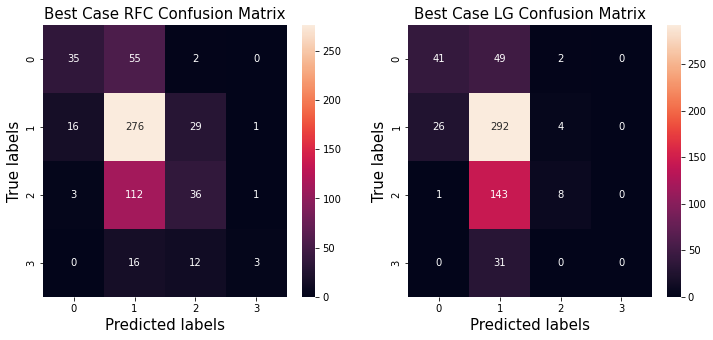

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, rfcs[bestRFCval].predict(X_test)), annot=True, fmt='g', ax=ax1)
ax1.set_xlabel('Predicted labels',fontsize=15)
ax1.set_ylabel('True labels',fontsize=15)
ax1.set_title('Best Case RFC Confusion Matrix',fontsize=15)

bestLG, bestPCA = lgs[bestLGval]
X_transformed = bestPCA.transform(X)
sns.heatmap(confusion_matrix(y_test, bestLG.predict(bestPCA.transform(X_test))), annot=True, fmt='g', ax=ax2)
ax2.set_xlabel('Predicted labels', fontsize=15)
ax2.set_ylabel('True labels', fontsize=15)
ax2.set_title('Best Case LG Confusion Matrix', fontsize=15)

print(f"In the best case LG, the TEST accuracy score is {accuracy_score(y_test, rfcs[bestRFCval].predict(X_test))}")
print(f"In the best case RFC, the TEST accuracy score is {accuracy_score(y_test, bestLG.predict(bestPCA.transform(X_test)))}")
plt.show()